# Overview

#### Here we have a dataset of houses sold in Connecticut near the beginning of 2021. For simplicity, we only consider single family houses. Ultimately, we wish to build a model for the price at which each house sold for, based on its characteristics listed on real estate websites. Such characteristics often include internal square footage, the year it was built, the bedroom count, the bathroom count, and the area of the lot. But there is also usually a lengthy description written by the real estate agent. Is there any additional information hidden in such a description that would help improve the model of the price? This is the question we focus on answering here.

#### The difficult thing about answering such a question is that the description is written in natural language with thousands of different possible words. Here we use a natural language processing tool called topic models. While most people are probably familiar with this tool being used to sort documents into human-recognizable topic groups, it can also be viewed as a dimensional reduction of text data. Instead of using thousands of possible words, and how many times they show up in each house description, we reduce the dimension to a significantly smaller number of topics that make up each description.

#### These topics can then be used with the other quantitative variables in a linear model with the house price as the response variable. 

In [1]:
import numpy as np
import pandas as pd
import re
import gensim

from collections import Counter

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Read in and clean up the data

In [2]:
d1 = pd.read_csv("zillow_ct_1-500.csv")
d2 = pd.read_csv("zillow_ct_501-1000.csv")
d3 = pd.read_csv("zillow_ct_1001-1500.csv")
d = pd.concat([d1, d2, d3]).reset_index()
d.loc[pd.isna(d.loc[:,"DESCRIPTION"]),"DESCRIPTION"] = ""
d = d.drop(columns=['index', 'TYPE'])
def cleanlot(l):
    if pd.isna(l):
        return np.nan
    elif l.split()[1] == 'nan' or l.split()[1] == "Data":
        return np.nan
    elif l.split()[1] == 'sqft':
        return float(l.split()[0].replace(',',''))*2.29568e-5
    else:
        return float(l.split()[0])
d.loc[:,"LOTSIZE"] = np.array([cleanlot(l) for l in d.LOTSIZE.values])

In [3]:
import glob
files = glob.glob("CT_houses/*")
d4 = pd.read_csv(files[0])
for f in files[1:]:
    d4 = pd.concat([d4, pd.read_csv(f)])
d4.loc[:,"Price"] = np.array([float(p.replace('$','').replace(',','')) for p in d4.Price.values if not pd.isna(p)])
def bedclean(b):
    if b.split()[0] == '--' or b.split()[0] == "Studio":
        return 0
    else:
        return int(b.split()[0])
d4.loc[:,"Bed"] = np.array([bedclean(b) for b in d4.Bed.values])
d4.loc[:,"Bath"] = np.array([0 if b.split()[0] == '--' else int(b.split()[0]) for b in d4.Bath.values])
d4.loc[:,"Area"] = np.array([np.nan if a.split()[0] == '--' else int(a.split()[0].replace(',','')) for a in d4.Area.values])
def cleanbuilt(b):
    if b == "No Data" or b == " ":
        return np.nan
    else:
        return int(b)
d4.loc[:,"Built"] = np.array([cleanbuilt(b) for b in d4.Built.values])
def cleanlot2(l):
    if len(l.split()) < 2:
        return np.nan
    elif ' sqft' in l:
        return float(l.split(' sqft')[0].replace(',',''))*2.29568e-5
    elif ' Acres' in l:
        l2 = l.split()
        return float(np.array(l2)[np.where(np.array(l2) == "Acres")[0] - 1])
    else:
        return np.nan
d4.loc[:,"Lot"] = np.array([cleanlot2(l) for l in d4.Lot.values])
d4 = pd.DataFrame({"AREA": d4.Area.values, 
                   "BED": d4.Bed.values,
                   "BATH": d4.Bath.values,
                   "BUILT": d4.Built.values,
                   "DESCRIPTION": d4.Description.values,
                   "LOTSIZE": d4.Lot.values,
                   "PRICE": d4.Price.values})

In [4]:
nonduplicates = np.array([i for i in range(d4.shape[0]) if not d4.DESCRIPTION.values[i] in d.DESCRIPTION.values])

In [5]:
d = pd.concat([d, d4.loc[nonduplicates]])
d = d.loc[~pd.isna(d.DESCRIPTION.values)].reset_index()
d

,index,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE
0,0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0
1,1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0
2,2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0
3,3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0
4,4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0
...,...,...,...,...,...,...,...,...
2149,818,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0
2150,819,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0
2151,820,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0
2152,821,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0


## Let's look at one of the descriptions as an example.

In [6]:
d.loc[10,"DESCRIPTION"]

"One of Ridgefield's most admired homes, custom built with absolutely no expense spared. Stunning Stone and Clapboard New England Colonial with exceptional architectural details throughout, beautifully sited on 1.48 park-like acres. The heart of this home features an updated gourmet Kitchen with Dacor double ovens, Viking cook top and Sub Zero Refrigerator. Gorgeous Taj Mahal Quartz counters and island with Tumbled Limestone back splash. Stylish Living Room with propane fireplace and spacious Dining Room with large Butler's pantry also with quartz and tumbled marble. Handsome Cherry paneled Library and sun filled Family Room with fireplace and built-in cabinets and desk. The Upper level features a large Master Suite with custom marble bath and generous walk-in closet. Three Bedrooms are en suite; and two bedrooms share a lovely Jack n Jill Bathroom. Large, custom Laundry Room and over sized Bonus Room round out the second floor. Other convenient features include front and rear staircas

### Clean up the text a bit and separate into tokens

In [7]:
desc = [re.sub(r'-', ' ', des).lower().strip().split() for des in d.loc[:,"DESCRIPTION"]]
apostrophe = desc[0][-9][-2]
desc = [[tkn.split("'s")[0].split(apostrophe+"s")[0] for tkn in tokens] for tokens in desc]

In [8]:
def has_numerics(string):
    return any(ch.isnumeric() for ch in string)

def is_cont(string):
    return "'" in string or apostrophe in string

def remove_string(string):
    return has_numerics(string) or is_cont(string)

In [9]:
desc = [[re.sub(r'[^\w\s]','',tkn) for tkn in tokens if not remove_string(tkn)] for tokens in desc]
desc = [[tkn for tkn in tokens if not tkn == ''] for tokens in desc]

In [10]:
np.array(desc[10])

array(['one', 'of', 'ridgefield', 'most', 'admired', 'homes', 'custom',
       'built', 'with', 'absolutely', 'no', 'expense', 'spared',
       'stunning', 'stone', 'and', 'clapboard', 'new', 'england',
       'colonial', 'with', 'exceptional', 'architectural', 'details',
       'throughout', 'beautifully', 'sited', 'on', 'park', 'like',
       'acres', 'the', 'heart', 'of', 'this', 'home', 'features', 'an',
       'updated', 'gourmet', 'kitchen', 'with', 'dacor', 'double',
       'ovens', 'viking', 'cook', 'top', 'and', 'sub', 'zero',
       'refrigerator', 'gorgeous', 'taj', 'mahal', 'quartz', 'counters',
       'and', 'island', 'with', 'tumbled', 'limestone', 'back', 'splash',
       'stylish', 'living', 'room', 'with', 'propane', 'fireplace', 'and',
       'spacious', 'dining', 'room', 'with', 'large', 'butler', 'pantry',
       'also', 'with', 'quartz', 'and', 'tumbled', 'marble', 'handsome',
       'cherry', 'paneled', 'library', 'and', 'sun', 'filled', 'family',
       'room', '

### Count how many times each word occurs throughout all the descriptions

In [11]:
vocab = Counter()
for desc_tkns in desc:
    vocab.update(desc_tkns)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 9482


### Remove words that are either too common or too rare

In [12]:
vocab = Counter(token for token in vocab.elements() if vocab[token] > 5)
stop_words = [item[0] for item in vocab.most_common(13)]
vocab = Counter(token for token in vocab.elements() if token not in stop_words)
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 2657


### Build a mapping between unique words and integers

In [13]:
id2word = {idx: pair[0] for idx, pair in enumerate(vocab.items())}
word2id = {pair[0]: idx for idx, pair in enumerate(vocab.items())}

s = 'nyc'
print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for '%s': %d" % (s,word2id[s]))
print("Word for identifier %d: %s" % (word2id[s], id2word[word2id[s]]))

Number of tokens mapped: 2657
Identifier for 'nyc': 544
Word for identifier 544: nyc


In [14]:
desc = [[tkn for tkn in tokens if tkn in vocab] for tokens in desc]

In [15]:
#remove homes with very few remaining tokens
keep = np.where(np.array([len(tokens) for tokens in desc]) >= 5)[0]
d = d.loc[keep]
desc = [tokens for tokens in desc if len(tokens) >= 5]

In [16]:
corpus = []
for tokens in desc:
    tkn_count = Counter(tokens)
    corpus.append([(word2id[item[0]], item[1]) for item in tkn_count.items()])
    
print("Abstract, tokenized:\n", desc[10], "\n")
print("Abstract, in corpus format:\n", corpus[10])

Abstract, tokenized:
 ['one', 'ridgefield', 'most', 'homes', 'custom', 'built', 'absolutely', 'no', 'expense', 'spared', 'stunning', 'stone', 'clapboard', 'new', 'england', 'colonial', 'exceptional', 'architectural', 'details', 'throughout', 'beautifully', 'sited', 'park', 'like', 'acres', 'heart', 'features', 'an', 'updated', 'gourmet', 'kitchen', 'dacor', 'double', 'ovens', 'viking', 'cook', 'top', 'sub', 'zero', 'refrigerator', 'gorgeous', 'quartz', 'counters', 'island', 'limestone', 'back', 'splash', 'stylish', 'living', 'propane', 'fireplace', 'spacious', 'dining', 'large', 'butler', 'pantry', 'also', 'quartz', 'marble', 'handsome', 'cherry', 'paneled', 'library', 'sun', 'filled', 'family', 'fireplace', 'built', 'cabinets', 'desk', 'upper', 'level', 'features', 'large', 'master', 'suite', 'custom', 'marble', 'bath', 'generous', 'walk', 'closet', 'three', 'bedrooms', 'are', 'en', 'suite', 'two', 'bedrooms', 'share', 'lovely', 'jack', 'n', 'jill', 'bathroom', 'large', 'custom', 'lau

## Build a Topic Model with 10 topics

In [17]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

CPU times: user 6.75 s, sys: 6.61 ms, total: 6.76 s
Wall time: 6.78 s


In [18]:
num_topics = 10
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = lda_model.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,1,new,level,views,floor,spaces,you,acres,property,ft,pool
1,2,appliances,living,private,bath,elegant,your,land,beach,sq,house
2,3,stainless,bedrooms,from,kitchen,custom,will,lot,or,post,sound
3,4,updated,full,an,master,studio,be,building,location,between,suite
4,5,steel,kitchen,by,walk,architect,it,seller,from,zoned,guest
5,6,remodeled,garage,living,large,experience,that,cheshire,located,sets,marble
6,7,renovated,space,island,open,exercise,have,agent,at,circular,stone
7,8,granite,has,waterfront,fireplace,dual,are,road,it,hardware,rooms
8,9,brand,bedroom,outdoor,full,direct,can,efficiency,opportunity,period,wine
9,10,roof,large,enjoy,bedroom,designed,all,rd,all,among,staircase


In [19]:
sample = 10
topic_dist = lda_model.get_document_topics(corpus[sample])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities
topic_dist_table

,Topic,Probabilities
0,0,0.020556
1,1,0.100280
2,2,0.070294
3,3,0.446744
4,5,0.014332
5,7,0.110208
6,9,0.228064


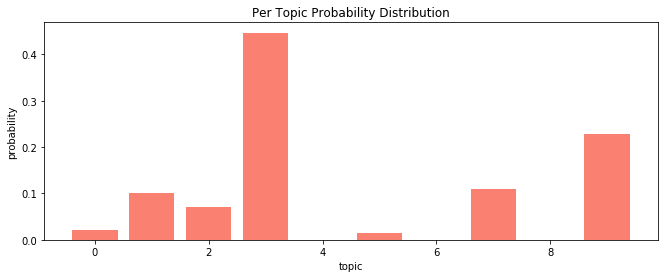

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table['Topic'], topic_dist_table['Probabilities'], align='center', alpha=1, color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

In [21]:
d.loc[sample,"DESCRIPTION"]

"One of Ridgefield's most admired homes, custom built with absolutely no expense spared. Stunning Stone and Clapboard New England Colonial with exceptional architectural details throughout, beautifully sited on 1.48 park-like acres. The heart of this home features an updated gourmet Kitchen with Dacor double ovens, Viking cook top and Sub Zero Refrigerator. Gorgeous Taj Mahal Quartz counters and island with Tumbled Limestone back splash. Stylish Living Room with propane fireplace and spacious Dining Room with large Butler's pantry also with quartz and tumbled marble. Handsome Cherry paneled Library and sun filled Family Room with fireplace and built-in cabinets and desk. The Upper level features a large Master Suite with custom marble bath and generous walk-in closet. Three Bedrooms are en suite; and two bedrooms share a lovely Jack n Jill Bathroom. Large, custom Laundry Room and over sized Bonus Room round out the second floor. Other convenient features include front and rear staircas

## Include the topic distribution for each house in a linear model

In [22]:
topics = pd.DataFrame({"Topic0": np.zeros(d.shape[0])})
for t in range(1,num_topics):
    topics["Topic"+str(t)] = np.zeros(d.shape[0])
for i in range(d.shape[0]):
    for t in lda_model.get_document_topics(corpus[i]):
        topics.loc[i,"Topic"+str(t[0])] = t[1]

In [23]:
topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0.083655,0.265730,0.024441,0.121445,0.000000,0.252397,0.000000,0.212714,0.000000,0.032522
1,0.236970,0.322296,0.021817,0.169022,0.000000,0.171856,0.000000,0.057473,0.000000,0.010963
2,0.139924,0.204573,0.021464,0.034294,0.000000,0.167082,0.027732,0.393740,0.000000,0.000000
3,0.103487,0.359452,0.107326,0.341467,0.000000,0.066478,0.000000,0.014457,0.000000,0.000000
4,0.212829,0.261390,0.022332,0.380803,0.000000,0.024193,0.000000,0.086683,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2138,0.247967,0.376383,0.019547,0.151743,0.000000,0.093347,0.000000,0.075137,0.012707,0.017268
2139,0.074201,0.150564,0.132911,0.457439,0.000000,0.075416,0.000000,0.092348,0.000000,0.000000
2140,0.000000,0.090201,0.166689,0.149316,0.012792,0.218981,0.012101,0.273104,0.000000,0.067930
2141,0.035328,0.136612,0.153157,0.108747,0.025940,0.086261,0.000000,0.372150,0.036241,0.042956


### But before we do that we need to clean up the other variables a bit.

In [24]:
d2 = d.reset_index().drop(columns=['level_0','index']).join(topics).dropna()

In [25]:
d2.columns

Index(['AREA', 'BED', 'BATH', 'BUILT', 'DESCRIPTION', 'LOTSIZE', 'PRICE',
       'Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6',
       'Topic7', 'Topic8', 'Topic9'],
      dtype='object')

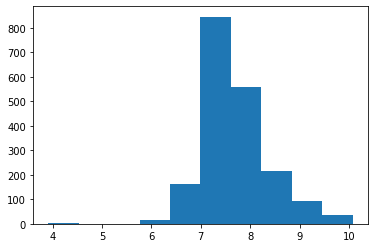

In [26]:
plt.hist(np.log(d2.AREA.values))
plt.show()

In [27]:
d2["logArea"] = np.log(d2.AREA.values)

In [28]:
d2.BED.value_counts(dropna=False).sort_index()

0.0       3
1.0      31
2.0     180
3.0     839
4.0     560
5.0     165
6.0      81
7.0      37
8.0      15
9.0       7
10.0      5
11.0      2
14.0      1
19.0      1
Name: BED, dtype: int64

In [29]:
d2.BATH.value_counts(dropna=False).sort_index()

0.0       3
1.0     326
2.0     700
3.0     481
4.0     163
5.0      84
6.0      43
7.0      28
8.0      21
9.0      25
10.0     17
11.0     15
12.0      8
13.0      7
14.0      2
16.0      1
17.0      1
18.0      1
24.0      1
Name: BATH, dtype: int64

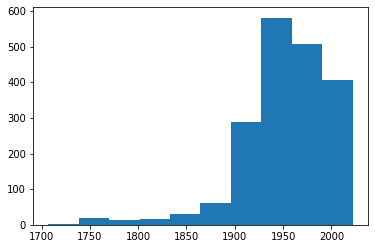

In [30]:
plt.hist(d2.BUILT.values)
plt.show()

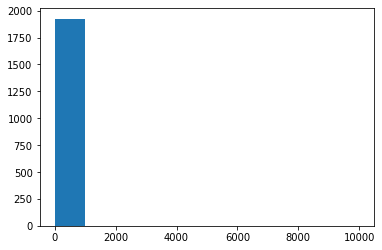

In [31]:
plt.hist(d2.LOTSIZE.values)
plt.show()

In [32]:
d2 = d2.iloc[np.where(d2.LOTSIZE.values < 1000)[0]]

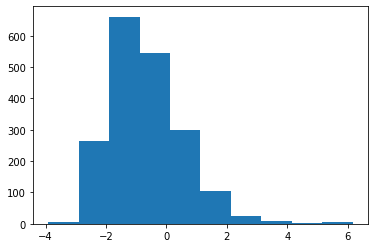

In [33]:
plt.hist(np.log(d2.LOTSIZE.values))
plt.show()

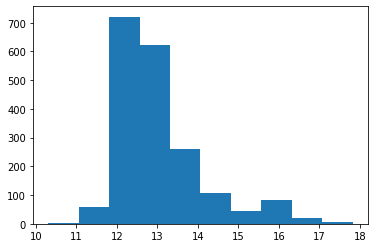

In [34]:
plt.hist(np.log(d2.PRICE.values))
plt.show()

In [35]:
d2["logLOTSIZE"] = np.log(d2.LOTSIZE.values)
d2["logPRICE"] = np.log(d2.PRICE.values)

In [36]:
import statsmodels.formula.api as sm

In [37]:
d2.columns

Index(['AREA', 'BED', 'BATH', 'BUILT', 'DESCRIPTION', 'LOTSIZE', 'PRICE',
       'Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6',
       'Topic7', 'Topic8', 'Topic9', 'logArea', 'logLOTSIZE', 'logPRICE'],
      dtype='object')

### Model with the Topics included

In [38]:
model = sm.ols("logPRICE ~ logArea + logLOTSIZE + BED + BATH + BUILT + Topic0 + " +
               "Topic1 + Topic2 + Topic3 + Topic4 + Topic5 + Topic6 + Topic7 + Topic8", data=d2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     767.2
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:03:43   Log-Likelihood:                -1033.6
No. Observations:                1925   AIC:                             2097.
Df Residuals:                    1910   BIC:                             2181.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0236      0.531     17.005      0.000       7.983      10.064
logArea        0.4818      0.033     14.587      0.000       0.417       0.547
logLOTSIZE     0.0228      0.010      2.298      0.022       0.003       0.042
BED           -0.0041      0.013     -0.326      0.744      -0.029       0.021
BATH           0.1304      0.010     12.642      0.000       0.110       0.151
BUILT          0.0014      0.000      6.274      0.000       0.001       0.002
Topic0        -2.7574      0.295     -9.340      0.000      -3.336      -2.178
Topic1        -3.5305      0.256    -13.811      0.000      -4.032      -3.029
Topic2        -0.7688      0.302     -2.544      0.011      -1.361      -0.176
Topic3        -2.9250      0.260    -11.258      0.000      -3.435      -2.415
Topic4         0.8590      0.573      1.499      0.134      -0.264       1.982
Topic5        -3.5003      0.269    -13.034      0.000      -4.027      -2.974
Topic6        -1.1744      0.524     -2.240      0.025      -2.203      -0.146
Topic7        -3.2084      0.274    -11.719      0.000      -3.745      -2.671
Topic8        -4.0629      0.944     -4.303      0.000      -5.915      -2.211
==============================================================================
Omnibus:                      166.787   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.106
Skew:                           0.449   Prob(JB):                    2.78e-106
Kurtosis:                       5.292   Cond. No.                     2.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

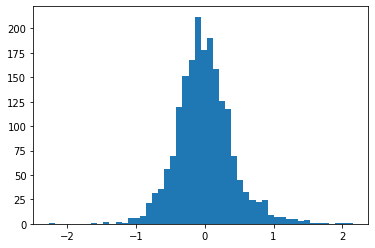

In [39]:
plt.hist(model.resid, bins=50)
plt.show()

### Model without the topics included

In [40]:
model2 = sm.ols("logPRICE ~ logArea + logLOTSIZE + BED + BATH + BUILT", data=d2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1429.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:03:52   Log-Likelihood:                -1359.2
No. Observations:                1925   AIC:                             2730.
Df Residuals:                    1919   BIC:                             2764.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1053      0.527     11.589      0.000       5.072       7.139
logArea        0.7015      0.035     19.795      0.000       0.632       0.771
logLOTSIZE     0.0842      0.011      7.700      0.000       0.063       0.106
BED           -0.0634      0.015     -4.337      0.000      -0.092      -0.035
BATH           0.2392      0.011     22.016      0.000       0.218       0.260
BUILT          0.0006      0.000      2.327      0.020    9.06e-05       0.001
==============================================================================
Omnibus:                      275.408   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.750
Skew:                           0.739   Prob(JB):                    4.42e-178
Kurtosis:                       5.829   Cond. No.                     9.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

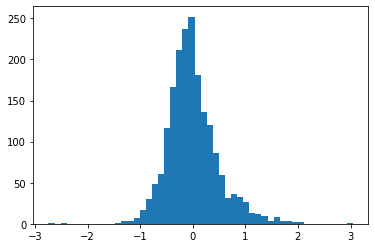

In [41]:
plt.hist(model2.resid, bins=50)
plt.show()

## What is the optimal number of topics for our purposes?

#### To answer this question we use three well-known model selection criteria: leave-one-out cross validation, AIC, and BIC.

In [42]:
num_topics = [2,3,4,5,6,8,10,12,14,16,18,20,21,22,23,24,26,28,30]
loocv = []
models = []
bics = []
aics = []
for num in num_topics:
    tmod = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    topics = pd.DataFrame({"Topic0": np.zeros(d.shape[0])})
    for t in range(1,num):
        topics["Topic"+str(t)] = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        for t in tmod.get_document_topics(corpus[i]):
            topics.loc[i,"Topic"+str(t[0])] = t[1]
    d2 = d.reset_index().drop(columns=['level_0','index']).join(topics).dropna()
    d2["logArea"] = np.log(d2.AREA.values)
    d2 = d2.iloc[np.where(d2.LOTSIZE.values < 1000)[0]]
    d2["logLOTSIZE"] = np.log(d2.LOTSIZE.values)
    d2["logPRICE"] = np.log(d2.PRICE.values)
    model = sm.ols("logPRICE ~ logArea + logLOTSIZE + BED + BATH + BUILT + Topic" +
               " + Topic".join([str(i) for i in range(num-1)]), data=d2).fit()
    loocv.append(np.mean((model.resid/(1 - model.get_influence().hat_matrix_diag))**2))
    bics.append(model.bic)
    aics.append(model.aic)
    models.append(model)

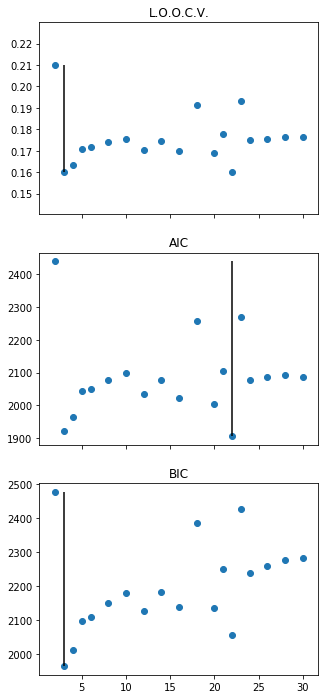

In [43]:
fig, ax = plt.subplots(3,1, figsize=(5,12),sharex=True)

ax[0].scatter(num_topics, loocv)
ax[0].vlines(num_topics[np.argmin(loocv)], ymin=min(loocv), ymax=max(loocv))
ax[0].set_title("L.O.O.C.V.")

ax[1].scatter(num_topics, aics)
ax[1].vlines(num_topics[np.argmin(aics)], ymin=min(aics), ymax=max(aics))
ax[1].set_title("AIC")

ax[2].scatter(num_topics, bics)
ax[2].vlines(num_topics[np.argmin(bics)], ymin=min(bics), ymax=max(bics))
ax[2].set_title("BIC")

plt.show()

### So it looks like either the optimal number of topics is 3 or 22. Since those are quite different, we'll try both and see if they give similar answers to whether or not the topics are important in the model.

### Model with 3 topics

In [44]:
models[np.argmin(bics)].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1700.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:08:29   Log-Likelihood:                -952.11
No. Observations:                1925   AIC:                             1920.
Df Residuals:                    1917   BIC:                             1965.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9391      0.448     19.967      0.000       8.061       9.817
logArea        0.4123      0.030     13.528      0.000       0.353       0.472
logLOTSIZE     0.0471      0.009      5.242      0.000       0.029       0.065
BED           -0.0006      0.012     -0.051      0.959      -0.024       0.023
BATH           0.1260      0.010     13.209      0.000       0.107       0.145
BUILT          0.0011      0.000      5.478      0.000       0.001       0.002
Topic0        -2.0460      0.072    -28.368      0.000      -2.187      -1.905
Topic1        -1.9475      0.062    -31.233      0.000      -2.070      -1.825
==============================================================================
Omnibus:                      163.191   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              566.089
Skew:                           0.379   Prob(JB):                    1.19e-123
Kurtosis:                       5.546   Cond. No.                     9.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Run an F-test to see if the topics are a statistically-significant set of variables in the model.

In [45]:
#F-test p-value:
models[np.argmin(bics)].compare_f_test(model2)[1]

8.895808255076282e-177

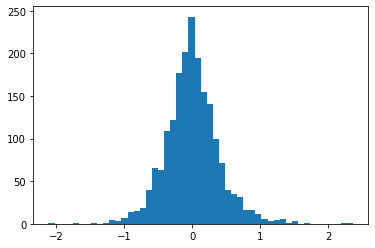

In [46]:
#histogram of residuals
plt.hist(models[np.argmin(bics)].resid, bins=50)
plt.show()

In [54]:
#percent decrease of the mean-squared-error by using the description
100*(model2.mse_resid - models[np.argmin(bics)].mse_resid)/model2.mse_resid

34.418762534142466

### Model with 22 topics

In [47]:
models[np.argmin(aics)].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     467.6
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:08:43   Log-Likelihood:                -926.13
No. Observations:                1925   AIC:                             1906.
Df Residuals:                    1898   BIC:                             2056.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0056      0.632     11.088      0.000       5.766       8.245
logArea        0.4953      0.032     15.611      0.000       0.433       0.558
logLOTSIZE     0.0974      0.010      9.812      0.000       0.078       0.117
BED           -0.0103      0.012     -0.856      0.392      -0.034       0.013
BATH           0.1511      0.009     15.962      0.000       0.133       0.170
BUILT          0.0006      0.000      3.001      0.003       0.000       0.001
Topic0        -2.2994      0.859     -2.677      0.007      -3.984      -0.615
Topic1        -0.1509      0.536     -0.282      0.778      -1.202       0.900
Topic2         1.8870      0.499      3.785      0.000       0.909       2.865
Topic3         1.0251      0.583      1.758      0.079      -0.118       2.168
Topic4         3.9764      0.543      7.322      0.000       2.911       5.042
Topic5         0.7898      0.855      0.924      0.356      -0.887       2.467
Topic6         3.4151      0.797      4.283      0.000       1.851       4.979
Topic7         0.5956      0.494      1.206      0.228      -0.373       1.564
Topic8         3.7382      3.667      1.019      0.308      -3.454      10.930
Topic9         0.9223      1.237      0.745      0.456      -1.504       3.349
Topic10        0.5424      0.478      1.136      0.256      -0.394       1.479
Topic11        0.0774      0.464      0.167      0.868      -0.833       0.988
Topic12       11.7050      0.657     17.824      0.000      10.417      12.993
Topic13       -3.2876      1.499     -2.193      0.028      -6.228      -0.347
Topic14        0.0953      0.471      0.202      0.840      -0.828       1.019
Topic15       -0.5706      0.584     -0.977      0.329      -1.716       0.574
Topic16       -1.2762      2.238     -0.570      0.569      -5.666       3.113
Topic17        9.0022      1.296      6.948      0.000       6.461      11.543
Topic18        5.7862      5.813      0.995      0.320      -5.615      17.187
Topic19       -2.8101      1.068     -2.630      0.009      -4.905      -0.715
Topic20        2.4713      0.574      4.306      0.000       1.346       3.597
==============================================================================
Omnibus:                      171.029   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              651.886
Skew:                           0.370   Prob(JB):                    2.78e-142
Kurtosis:                       5.753   Cond. No.                     1.26e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
""

In [48]:
models[np.argmin(aics)].compare_f_test(model2)[1]

4.373299231042261e-168

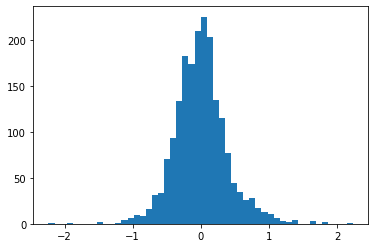

In [49]:
plt.hist(models[np.argmin(aics)].resid, bins=50)
plt.show()

In [53]:
#percent decrease of the mean-squared-error by using the description
100*(model2.mse_resid - models[np.argmin(aics)].mse_resid)/model2.mse_resid

35.52625490617793

### So in both cases we find that the description provides statistically significant information that helps model the price! But what about the description should one look for?

In [64]:
finalmod = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=3, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
topics = pd.DataFrame({"Topic0": np.zeros(d.shape[0])})
for t in range(1,3):
    topics["Topic"+str(t)] = np.zeros(d.shape[0])
for i in range(d.shape[0]):
    for t in finalmod.get_document_topics(corpus[i]):
        topics.loc[i,"Topic"+str(t[0])] = t[1]
d2 = d.reset_index().drop(columns=['level_0','index']).join(topics).dropna()
d2["logArea"] = np.log(d2.AREA.values)
d2 = d2.iloc[np.where(d2.LOTSIZE.values < 1000)[0]]
d2["logLOTSIZE"] = np.log(d2.LOTSIZE.values)
d2["logPRICE"] = np.log(d2.PRICE.values)
model = sm.ols("logPRICE ~ logArea + logLOTSIZE + BED + BATH + BUILT + Topic" +
               " + Topic".join([str(i) for i in range(3-1)]), data=d2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1700.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:24:41   Log-Likelihood:                -952.11
No. Observations:                1925   AIC:                             1920.
Df Residuals:                    1917   BIC:                             1965.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9391      0.448     19.967      0.000       8.061       9.817
logArea        0.4123      0.030     13.528      0.000       0.353       0.472
logLOTSIZE     0.0471      0.009      5.242      0.000       0.029       0.065
BED           -0.0006      0.012     -0.051      0.959      -0.024       0.023
BATH           0.1260      0.010     13.209      0.000       0.107       0.145
BUILT          0.0011      0.000      5.478      0.000       0.001       0.002
Topic0        -2.0460      0.072    -28.368      0.000      -2.187      -1.905
Topic1        -1.9475      0.062    -31.233      0.000      -2.070      -1.825
==============================================================================
Omnibus:                      163.191   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              566.089
Skew:                           0.379   Prob(JB):                    1.19e-123
Kurtosis:                       5.546   Cond. No.                     9.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
model.compare_f_test(model2)

(504.57089813535237, 8.895808255076282e-177, 2.0)

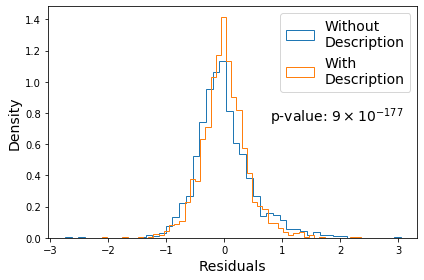

In [78]:
plt.hist(model2.resid, bins=50, histtype='step', density=True, label='Without\nDescription')
plt.hist(model.resid, bins=50, histtype='step', density=True, label='With\nDescription')
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.text(0.8,0.75,r"p-value: $9\times 10^{-177}$", fontsize=14)

plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig("topicmodel_resids")
plt.show()

In [66]:
num_topics = 3
num_words = 25
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = finalmod.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2
0,1,your,kitchen,views
1,2,be,level,an
2,3,property,has,private
3,4,as,full,suite
4,5,or,bath,beach
5,6,new,floor,custom
6,7,it,large,from
7,8,will,living,floor
8,9,lot,new,by
9,10,at,bedrooms,island


#### So it appears from the model that the two first topics are talking about just the basic necessities of a home. Whereas the third topic is all about add-on luxuries! And the linear model suggests that the less frequently this third topic is used in the description, the price will drop significantly. In fact, since the t-scores of the coefficients for the topics are the two largest in the model, this suggests that the mention of luxuries in the description has a greater influence on the price than the other variables.

# Conclusion

#### In both scenarios of the possible optimal number of topics being 3 or 22, the p-value from running an F-test on the topics was absolutely tiny! Formally, we should use post-selection inference techniques to get the p-value. But in this scenario since the p-values are nowhere close to being large, those techniques will almost certainly not change this conclusion. 

#### We find that the topics are a statistically-significant set of variables in predicting the price of sold houses in Connecticut! Furthermore, the dimensionally-reduced description appears to have a greater influence on the price than internal area, lot size, bedroom count, bathroom count, and year built. So, long story short, before you buy a house READ THE DESCRIPTION!!!